# Testing Advanced Snapping
Running travel time to closest facility for health facilities, schools, and markets. Based off of: https://github.com/ywnch/toolbox/blob/master/demo_connect_poi.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely.geometry import Point
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

In [3]:
import os, sys

In [4]:
# Get reference to GOSTNets
import sys
sys.path.append(r'C:\repos\GOSTnets')
import GOSTnets as gn

In [5]:
from toolbox import connect_poi

In [6]:
# import extent
bounds = gpd.read_file("POLYGON.shp")

In [7]:
# define road graph
roadGraph = "OSM_Roads.pickle"

## Use OSMNX to download road network inside bounding box

In [8]:
if not os.path.exists(roadGraph):
    extent = box(*bounds.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    
    # Find the largest sub-graph compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph
    
    print('print G')
    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

C:\repos\GOSTnets\GOSTnets\core.py:763: UserWarning: Aree you sure you want to convert length to time? This graph already has a time attribute
  warnings.warn('Aree you sure you want to convert length to time? This graph already has a time attribute')


In [9]:
G

In [10]:
# find graph utm zone
G_utm = gn.utm_of_graph(G)
G_utm

'+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

### Load POIs

In [11]:
# insert POIs
POIs = gpd.read_file("POINT.shp")
POIs['key'] = POIs.index

In [12]:
POIs

,geometry,key
0,POINT (-77.67694 38.96048),0
1,POINT (-77.66330 38.98336),1
2,POINT (-77.65257 38.96301),2
3,POINT (-77.65394 38.97936),3
4,POINT (-77.63523 38.99577),4
5,POINT (-77.61806 38.96401),5
6,POINT (-77.66021 38.95600),6


## The New Advanced Snapping function

In [13]:
import time
start_time = time.time()

In [14]:
# it's a one-liner, but is still at beta at the moment G_utm
G2, new_nodes = gn.advanced_snap(G, POIs, u_tag = 'stnode', v_tag = 'endnode', poi_key_col='key', path=None, threshold=400, measure_crs=G_utm)

Building rtree...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 0/7 (0.00%)
NOTE: duplication in node coordinates keys
Nodes count: 7956
Node coordinates key count: 7955
Missing 'from' nodes: 0
Missing 'to' nodes: 0
print 1st edge
(63388025, 63388033, 0)


In [15]:
print(time.time() - start_time)

6.988314151763916


### You can use new_nodes to specify the orgins for your OD Matrix. The values under the key columns are the POIs/origins. They connect to the projected point (with the osmid) on the nearest line

In [16]:
new_nodes

,geometry,key,near_idx,near_lines,kne_idx,pp,osmid
0,POINT (-77.67694 38.96048),0,"[10969, 10973, 10972, 16784, 10971, 347]","10969 LINESTRING (268283.843 4315537.920, 2...",10969,POINT (268332.8919117243 4315729.196310355),9990000000
1,POINT (-77.66330 38.98336),1,"[2551, 17630, 17635, 17632, 18262, 17631]","2551 LINESTRING (269286.130 4318212.488, 2...",2551,POINT (269286.1296907349 4318212.487899968),9990000001
2,POINT (-77.65257 38.96301),2,"[528, 14916, 14919, 14918, 14885, 15456]","528 LINESTRING (270060.131 4316828.798, 2...",528,POINT (269921.5566800105 4316103.525978696),9990000002
3,POINT (-77.65394 38.97936),3,"[17213, 17217, 2740, 2058, 2742, 17212]","17213 LINESTRING (270128.151 4317724.989, 2...",17213,POINT (270114.1920907208 4317841.41909706),9990000003
4,POINT (-77.63523 38.99577),4,"[16186, 14401, 14398, 16185, 16187, 18851]","16186 LINESTRING (271922.650 4319810.073, 2...",16186,POINT (271885.1712819166 4319606.63655866),9990000004
5,POINT (-77.61806 38.96401),5,"[8694, 8698, 6860, 8699, 17044, 17045]","8694 LINESTRING (272849.425 4316126.850, 2...",8694,POINT (273123.1194834075 4316148.145612882),9990000005
6,POINT (-77.66021 38.95600),6,"[14346, 363, 14349, 14347, 14917, 14345]","14346 LINESTRING (269598.814 4315283.365, 2...",14346,POINT (269583.4011043146 4315231.71529806),9990000006


## Different ways to inspect Graphs

In [17]:
for edge in list(G2.edges):
    print(edge)
    print(G2.get_edge_data(edge[0],edge[1]))

(63388025, 63388033, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D654875EC8>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Visionary Court', 'oneway': False, 'time': 10.405260000000002, 'tunnel': nan, 'bridge': nan, 'length': 57.807, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 8799058, 'lanes': nan, 'key': nan}}
(63388033, 63388042, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D654875E48>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Visionary Court', 'oneway': False, 'time': 13.199399999999997, 'tunnel': nan, 'bridge': nan, 'length': 73.33, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 8799058, 'lanes': nan, 'key': nan}}
(63388033, 63388025, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D654875E08>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Visionary Court', 'oneway': Fal

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D654875948>, 'highway': 'residential', 'mode': 'drive', 'ref': 'SR 617', 'name': 'Red Hill Road', 'oneway': False, 'time': 137.28527999999997, 'tunnel': nan, 'bridge': nan, 'length': 762.6959999999999, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 8799078, 'lanes': nan, 'key': nan}}
(63388302, 7959174101, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D654875908>, 'highway': 'secondary', 'mode': 'drive', 'ref': 'VA 772', 'name': 'Ryan Road', 'oneway': False, 'time': 53.55648, 'tunnel': nan, 'bridge': nan, 'length': 446.304, 'maxspeed': '45 mph', 'junction': nan, 'service': nan, 'access': nan, 'osmid': [756119377, 756480209], 'lanes': nan, 'key': nan}}
(63388302, 6637455164, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6548758C8>, 'highway': 'secondary', 'mode': 'drive', 'ref': 'VA 621', 'name': 'Evergreen Mills Road', 'o

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D658567D88>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': nan, 'oneway': False, 'time': 6.08436, 'tunnel': nan, 'bridge': nan, 'length': 33.802, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 8801868, 'lanes': nan, 'key': nan}}
(7543545965, 7961841616, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D659D1E748>, 'highway': 'residential', 'mode': 'drive', 'ref': 'VA 780', 'name': 'Mossridge Road', 'oneway': False, 'time': 0.9374399999999999, 'tunnel': nan, 'bridge': nan, 'length': 5.208, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 806691112, 'lanes': nan, 'key': nan}}
(7543545965, 63419880, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D659D1E788>, 'highway': 'residential', 'mode': 'drive', 'ref': 'VA 780', 'name': 'Mossridge Road', 'oneway': False, 'time': 20.260800000000003, '

(63528631, 63528601, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6585E7EC8>, 'highway': 'tertiary', 'mode': 'drive', 'ref': 'VA 629', 'name': 'Champe Ford Road', 'oneway': False, 'time': 21.854400000000002, 'tunnel': nan, 'bridge': 'yes', 'length': 182.12, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': [8810534, 418028941, 418028942], 'lanes': nan, 'key': nan}}
(63426425, 63426418, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D658571A08>, 'highway': 'service', 'mode': 'drive', 'ref': nan, 'name': nan, 'oneway': False, 'time': 48.139739999999996, 'tunnel': nan, 'bridge': nan, 'length': 267.443, 'maxspeed': nan, 'junction': nan, 'service': 'driveway', 'access': nan, 'osmid': 436308726, 'lanes': nan, 'key': nan}}
(63426518, 518477281, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D658571A48>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': nan, 'one

(63454773, 63491152, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D658597C88>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'South Jay Street', 'oneway': False, 'time': 16.330319999999997, 'tunnel': nan, 'bridge': nan, 'length': 90.724, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 296374483, 'lanes': nan, 'key': nan}}
(63454773, 8301935995, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D658597CC8>, 'highway': ['service', 'residential'], 'mode': 'drive', 'ref': nan, 'name': 'East Federal Street', 'oneway': False, 'time': 81.71478, 'tunnel': nan, 'bridge': nan, 'length': 453.971, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': [8805233, 894481325, 893235713], 'lanes': nan, 'key': nan}}
(3001675628, 63454773, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D659A0FB08>, 'highway': 'service', 'mode': 'drive', 'ref': nan, 'nam

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6586AF108>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Cattail Meadows Place', 'oneway': False, 'time': 13.03668, 'tunnel': nan, 'bridge': nan, 'length': 72.426, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 8820728, 'lanes': nan, 'key': nan}}
(5276128393, 63457584, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D659B205C8>, 'highway': 'service', 'mode': 'drive', 'ref': nan, 'name': nan, 'oneway': False, 'time': 11.07216, 'tunnel': nan, 'bridge': nan, 'length': 61.512, 'maxspeed': nan, 'junction': nan, 'service': 'driveway', 'access': nan, 'osmid': 545923231, 'lanes': nan, 'key': nan}}
(63526831, 63457594, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6585E7848>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Sundance Square', 'oneway': False, 'time': 9.084420000000001, 'tunnel': nan

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6585C6988>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Pemberton Square', 'oneway': False, 'time': 9.5094, 'tunnel': nan, 'bridge': nan, 'length': 52.83, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 8814689, 'lanes': nan, 'key': nan}}
(63490368, 63490370, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6585C69C8>, 'highway': 'tertiary', 'mode': 'drive', 'ref': 'SR 621', 'name': 'Elk Lick Road', 'oneway': False, 'time': 8.986559999999999, 'tunnel': nan, 'bridge': nan, 'length': 74.88799999999999, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 216724307, 'lanes': '2', 'key': nan}}
(63598764, 63490368, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D658640C48>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Pemberton Square', 'oneway': False, 'time': 9.5094, 't

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D659A4A988>, 'highway': 'primary', 'mode': 'drive', 'ref': 'US 50', 'name': 'John Mosby Highway', 'oneway': False, 'time': 30.864419999999996, 'tunnel': nan, 'bridge': nan, 'length': 342.93800000000005, 'maxspeed': ['35 mph', '25 mph'], 'junction': nan, 'service': nan, 'access': nan, 'osmid': [244588553, 142913908], 'lanes': '2', 'key': nan}}
(4205406774, 4205406779, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D659A4A9C8>, 'highway': 'service', 'mode': 'drive', 'ref': nan, 'name': nan, 'oneway': False, 'time': 17.099999999999994, 'tunnel': nan, 'bridge': nan, 'length': 94.99999999999999, 'maxspeed': nan, 'junction': nan, 'service': 'driveway', 'access': nan, 'osmid': 420586288, 'lanes': nan, 'key': nan}}
(63494934, 2551797431, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6585D0288>, 'highway': 'tertiary', 'mode': 'drive', 'ref': nan, 'name': 'Du

(63603019, 63603009, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D658649888>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Fremont Preserve Square', 'oneway': False, 'time': 3.7063800000000007, 'tunnel': nan, 'bridge': nan, 'length': 20.591, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 8820583, 'lanes': nan, 'key': nan}}
(63603019, 63554635, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6586498C8>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Fremont Preserve Square', 'oneway': False, 'time': 13.657860000000001, 'tunnel': nan, 'bridge': nan, 'length': 75.87700000000001, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 8820583, 'lanes': nan, 'key': nan}}
(63555701, 2064110685, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6586172C8>, 'highway': 'tertiary', 'mode': 'drive', 'ref': nan, 'name': 'Mill

(63606753, 5276127974, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D658649E88>, 'highway': 'service', 'mode': 'drive', 'ref': nan, 'name': nan, 'oneway': False, 'time': 13.83732, 'tunnel': nan, 'bridge': nan, 'length': 76.874, 'maxspeed': nan, 'junction': nan, 'service': 'driveway', 'access': nan, 'osmid': 545923224, 'lanes': nan, 'key': nan}}
(63580624, 63580629, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D65862F208>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Bradford Forest Drive', 'oneway': False, 'time': 14.365980000000002, 'tunnel': nan, 'bridge': nan, 'length': 79.811, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 8813462, 'lanes': nan, 'key': nan}}
(63580624, 5039672411, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D65862F248>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Abney Wood Drive', 'oneway': False, 'ti

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6586AF808>, 'highway': 'service', 'mode': 'drive', 'ref': nan, 'name': 'Possum Pond Lane', 'oneway': False, 'time': 41.63922, 'tunnel': nan, 'bridge': nan, 'length': 231.329, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 20003508, 'lanes': nan, 'key': nan}}
(210419753, 210788138, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6586AF848>, 'highway': 'service', 'mode': 'drive', 'ref': nan, 'name': 'Possum Pond Lane', 'oneway': False, 'time': 99.77922000000001, 'tunnel': nan, 'bridge': nan, 'length': 554.3290000000001, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': [20003508, 20003509], 'lanes': nan, 'key': nan}}
(210419779, 210419753, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D6586AF888>, 'highway': 'service', 'mode': 'drive', 'ref': nan, 'name': nan, 'oneway': False, 'time': 54.5671799999999

{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D659CCA548>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Red Fox Court', 'oneway': False, 'time': 6.010739999999999, 'tunnel': nan, 'bridge': nan, 'length': 33.393, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 20444267, 'lanes': nan, 'key': nan}}
(7063330262, 218243806, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D659CCA588>, 'highway': 'residential', 'mode': 'drive', 'ref': nan, 'name': 'Red Fox Court', 'oneway': False, 'time': 8.8911, 'tunnel': nan, 'bridge': nan, 'length': 49.394999999999996, 'maxspeed': nan, 'junction': nan, 'service': nan, 'access': nan, 'osmid': 20444267, 'lanes': nan, 'key': nan}}
(7063330262, 7063330267, 0)
{0: {'geometry': <shapely.geometry.linestring.LineString object at 0x000001D659CCA5C8>, 'highway': 'service', 'mode': 'drive', 'ref': nan, 'name': nan, 'oneway': False, 'time': 8.348220000000001, 'tunne

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
list(G2.nodes(data=True))

[(63388025,
  {'node_ID': 63388025.0,
   'x': -77.5536578,
   'osmid': 63388025,
   'highway': 'turning_circle',
   'y': 38.91703840000001,
   'geometry': <shapely.geometry.point.Point at 0x1d654cfc488>}),
 (63388033,
  {'node_ID': 63388033.0,
   'x': -77.5530008,
   'osmid': 63388033,
   'y': 38.916946399999986,
   'geometry': <shapely.geometry.point.Point at 0x1d654d0bc08>}),
 (63388042,
  {'node_ID': 63388042.0,
   'x': -77.5521973,
   'osmid': 63388042,
   'highway': 'turning_circle',
   'y': 38.916792099999995,
   'geometry': <shapely.geometry.point.Point at 0x1d654d0b848>}),
 (63590128,
  {'node_ID': 63590128.0,
   'x': -77.5529327,
   'osmid': 63590128,
   'y': 38.917805600000015,
   'geometry': <shapely.geometry.point.Point at 0x1d6551eaa48>}),
 (63388052,
  {'node_ID': 63388052.0,
   'x': -77.52708200000001,
   'osmid': 63388052,
   'y': 38.912955000000004,
   'geometry': <shapely.geometry.point.Point at 0x1d6556612c8>}),
 (63388054,
  {'node_ID': 63388054.0,
   'x': -77.52591

In [19]:
# You can also convert graph to GeoDataFrames and inspect them
# pd.set_option('display.max_columns', None)
node_gdf = gn.node_gdf_from_graph(G2)
edge_gdf = gn.edge_gdf_from_graph(G2)
# edge_gdf

In [20]:
node_gdf[-20:]

,node_ID,osmid,highway,y,x,geometry
7936,8319821666,8319821666,turning_loop,38.915986,-77.598171,POINT (-77.59817 38.91599)
7937,8319845742,8319845742,NaN,38.919445,-77.597978,POINT (-77.59798 38.91945)
7938,8319821703,8319821703,NaN,38.922389,-77.598229,POINT (-77.59823 38.92239)
7939,8319821708,8319821708,NaN,38.922348,-77.597818,POINT (-77.59782 38.92235)
7940,8319821715,8319821715,NaN,38.922503,-77.597520,POINT (-77.59752 38.92250)
7941,8319845733,8319845733,turning_loop,38.918454,-77.599400,POINT (-77.59940 38.91845)
7942,9990000002,9990000002,projected_pap,38.963710,-77.655491,POINT (-77.65549 38.96371)
7943,9990000001,9990000001,projected_pap,38.982527,-77.663529,POINT (-77.66353 38.98253)
7944,9990000005,9990000005,projected_pap,38.964946,-77.618591,POINT (-77.61859 38.96495)
7945,9990000000,9990000000,projected_pap,38.959922,-77.673682,POINT (-77.67368 38.95992)


## Visualize

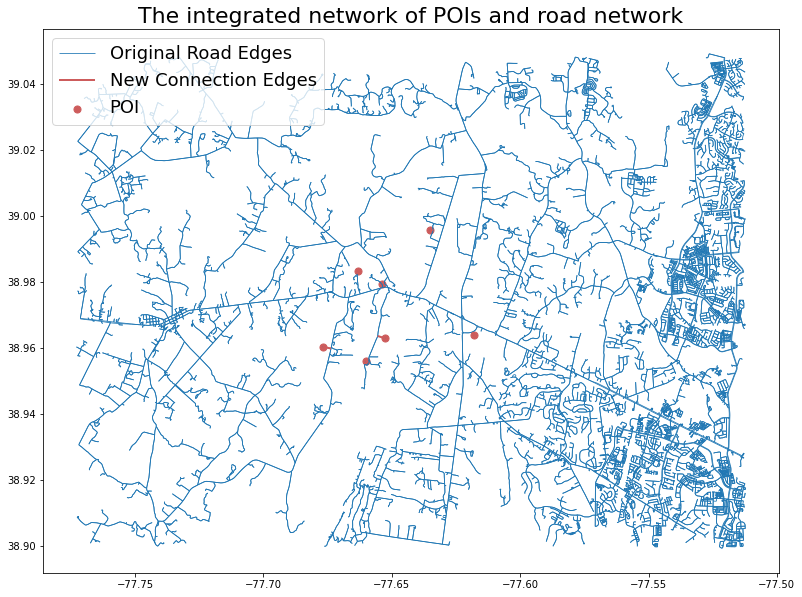

In [21]:
# output
# footways are added between the POIs and the closest lines
poi_links = edge_gdf[edge_gdf['highway'] == 'projected_footway']
ax = edge_gdf.plot(linewidth=0.8, figsize=(18,10), label='Original Road Edges')
poi_links.plot(color='indianred', linewidth=2, ax=ax, label='New Connection Edges')
POIs.plot(color='indianred', marker='.', markersize=200, ax=ax, label='POI')
ax.legend(loc=2, fontsize=18)
ax.set_title('The integrated network of POIs and road network', fontsize=22);

## Time Comparison
pandana_snap should be used if less accuracy is required and more speed is needed

In [22]:
#gn.pandana_snap?

In [23]:
snapped_origins = gn.pandana_snap(G,POIs, time_it=True)

time elapsed for function
0.18852448463439941


In [24]:
snapped_origins = gn.pandana_snap_c(G,POIs, time_it=True)

time elapsed for function
0.10073685646057129
